[*********************100%***********************]  1 of 1 completed


Feature dataframe shape: (1221, 22)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.694513
Fold 5: AUC=0.5936, Acc=0.5714, F1=0.6329, Brier=0.2369

OOF AUC: 0.593610192569539
OOF Brier: 0.23694173967433563
OOF Accuracy: 0.5714285714285714
Confusion Matrix:
 [[41 65]
 [22 75]]
Precision: 0.5357142857142857
Recall: 0.7731958762886598
F1: 0.6329113924050633

Top features by LightGBM importance:
 Price
atr_14             163
macd_hist           93
rsi_14              93
Close               92
lag_return_1d       88
obv_change_5d       84
return_3d           82
ma_20_ratio         80
Open                73
High                62
bb_pos              61
daily_range         61
return_1d           61
vol_spike_ratio     58
Volume              54
dtype: int32


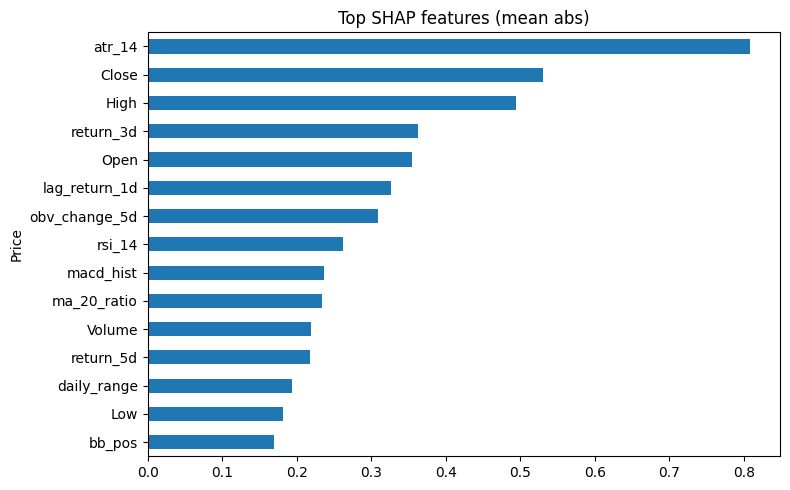


Backtest period: 2024-10-23 to 2025-08-11
Final market return: 1.03628990888171
Final strat return: 1.0199108272844155
Strategy Sharpe (daily): 1.1000634823608928
Market Sharpe (daily): 0.3160523371538143
                  Close      prob signal  pos  strat_ret_after_costs
Date                                                                
2024-10-23  1338.525024  0.537736   HOLD    0                    NaN
2024-10-24  1339.800049  0.537736   HOLD    0                   -0.0
2024-10-25  1327.849976  0.537736   HOLD    0                    0.0
2024-10-28  1334.349976  0.537736   HOLD    0                    0.0
2024-10-29  1340.000000  0.537736   HOLD    0                    0.0
2024-10-30  1343.900024  0.537736   HOLD    0                   -0.0
2024-10-31  1332.050049  0.537736   HOLD    0                    0.0
2024-11-01  1338.650024  0.537736   HOLD    0                   -0.0
2024-11-04  1302.150024  0.537736   HOLD    0                    0.0
2024-11-05  1305.300049  0.537736  

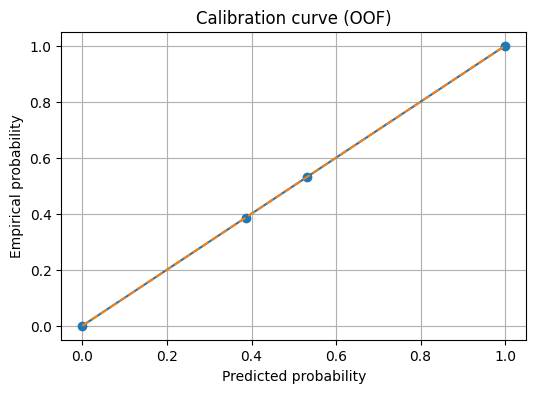


Saved model to lgb_5day_model.joblib and scaler to scaler.joblib


In [ ]:
# model_5day.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import early_stopping


from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import joblib

# -----------------
# CONFIG
# -----------------
TICKER = "RELIANCE.NS"      # change as needed, e.g. "^NSEI" for NIFTY 50
PERIOD = "5y"
INTERVAL = "1d"

USE_CSV = False             # set True if you prefer to load local CSV
CSV_PATH = "reliance.csv"   # if USE_CSV True, CSV should have Date,Open,High,Low,Close,Volume

RANDOM_SEED = 42
N_SPLITS = 5                # number of walk-forward folds for CV
TRANSACTION_COST = 0.0005   # e.g., 0.05% roundtrip cost (adjust)
PROB_THRESH_BUY = 0.60
PROB_THRESH_STRONG_BUY = 0.75
PROB_THRESH_SELL = 0.40

MODEL_OUT = "lgb_5day_model.joblib"
SCALER_OUT = "scaler.joblib"

np.random.seed(RANDOM_SEED)

# -----------------
# UTIL: feature engineering (same pack as earlier)
# -----------------
def compute_features(df):
    df = df.copy()
    df = df[['Open','High','Low','Close','Volume']].astype(float)

    # returns
    df['return_1d'] = df['Close'].pct_change(1)
    df['return_3d'] = df['Close'].pct_change(3)
    df['return_5d'] = df['Close'].pct_change(5)
    df['lag_return_1d'] = df['return_1d'].shift(1)
    df['price_change_intraday'] = (df['Close'] - df['Open']) / df['Open']

    # moving averages & ratios
    df['ma_5'] = df['Close'].rolling(5).mean()
    df['ma_10'] = df['Close'].rolling(10).mean()
    df['ma_20'] = df['Close'].rolling(20).mean()
    df['ma_5_ratio'] = df['Close'] / df['ma_5'] - 1
    df['ma_10_ratio'] = df['Close'] / df['ma_10'] - 1
    df['ma_20_ratio'] = df['Close'] / df['ma_20'] - 1
    df['ma_crossover_5_10'] = (df['ma_5'] > df['ma_10']).astype(int)

    # Bollinger band position
    rolling20 = df['Close'].rolling(20)
    std20 = rolling20.std()
    sma20 = rolling20.mean()
    df['bb_upper'] = sma20 + 2*std20
    df['bb_lower'] = sma20 - 2*std20
    df['bb_pos'] = (df['Close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    # RSI
    df['delta'] = df['Close'].diff()
    gain = df['delta'].where(df['delta'] > 0, 0)
    loss = -df['delta'].where(df['delta'] < 0, 0)
    df['rsi_14'] = gain.rolling(14).mean() / (gain.rolling(14).mean() + loss.rolling(14).mean())
    df['rsi_14'] = 100 - (100 / (1 + (gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-9))))
    # MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # Volume features
    df['vol_avg_10'] = df['Volume'].rolling(10).mean()
    df['vol_spike_ratio'] = df['Volume'] / (df['vol_avg_10'] + 1e-9)
    # OBV
    df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['obv_change_5d'] = df['obv'] - df['obv'].shift(5)

    # Volatility
    df['daily_range'] = (df['High'] - df['Low']) / df['Close']
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - df['Close'].shift()).abs()
    tr3 = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean()

    # Market context placeholders (user can compute & merge NIFTY externally)
    # Example: df['nifty_rel_3d'] = df['return_3d'] - nifty_return_3d

    # target: up in 5 trading days
    df['target'] = (df['Close'].shift(-5) > df['Close']).astype(int)

    # keep sensible columns
    keep = [
        'Close','Open','High','Low','Volume',
        'return_1d','return_3d','return_5d','lag_return_1d','price_change_intraday',
        'ma_5_ratio','ma_10_ratio','ma_20_ratio','ma_crossover_5_10','bb_pos',
        'rsi_14','macd_hist','vol_spike_ratio','obv_change_5d','atr_14','daily_range',
        'target'
    ]
    df = df[keep]
    df = df.dropna()
    return df

# -----------------
# LOAD DATA
# -----------------
if USE_CSV:
    assert os.path.exists(CSV_PATH), f"{CSV_PATH} not found"
    df_raw = pd.read_csv(CSV_PATH, parse_dates=['Date'], index_col='Date')
else:
    print(f"Downloading {TICKER} from yfinance...")
    df_raw = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
    if isinstance(df_raw.columns, pd.MultiIndex):
        # If user accidentally supplied multiple tickers, select the ticker block
        # For index tickers like ^NSEI this usually won't be necessary.
        try:
            df_raw = df_raw.xs(TICKER, axis=1, level=1)
        except Exception:
            # fallback: try to squeeze
            df_raw.columns = [c[0] if isinstance(c, tuple) else c for c in df_raw.columns]

if df_raw.empty:
    raise RuntimeError("No data downloaded. Check ticker or connection.")

df_raw.index = pd.to_datetime(df_raw.index)

# -----------------
# FEATURES
# -----------------
df = compute_features(df_raw)
print("Feature dataframe shape:", df.shape)

# -----------------
# Train-test split (time-aware)
# -----------------
# We'll keep the final fold as test, others for CV
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
X = df.drop(columns=['target'])
y = df['target'].astype(int)

# scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# Save scaler
joblib.dump(scaler, SCALER_OUT)

# -----------------
# Walk-forward CV training with LightGBM; store fold metrics
# -----------------
fold = 0
oof_preds = pd.Series(index=X_scaled.index, dtype=float)
models = []
metrics = []

for train_index, test_index in tscv.split(X_scaled):
    fold += 1
    X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val)

    params = {
        'objective': 'binary',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'metric': 'auc',
        'verbosity': -1,
        'seed': RANDOM_SEED
    }
# 1. Train LightGBM with sklearn API using callback for early stopping
lgb_clf = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    n_estimators=1000
)

lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='binary_logloss',
    callbacks=[early_stopping(stopping_rounds=50)]
)

# 2. Calibrate probabilities
clf = CalibratedClassifierCV(estimator=lgb_clf, method='isotonic', cv='prefit')
clf.fit(X_val, y_val)

# 3. Predictions
y_pred_proba = clf.predict_proba(X_val)[:, 1]
y_pred = clf.predict(X_val)

    # predict on validation
probs = clf.predict_proba(X_val)[:,1]
oof_preds.iloc[test_index] = probs
models.append(clf)

    # metrics for fold
auc = roc_auc_score(y_val, probs)
thresh = 0.5
preds_bin = (probs >= thresh).astype(int)
acc = accuracy_score(y_val, preds_bin)
prec = precision_score(y_val, preds_bin, zero_division=0)
rec = recall_score(y_val, preds_bin, zero_division=0)
f1 = f1_score(y_val, preds_bin, zero_division=0)
brier = brier_score_loss(y_val, probs)

metrics.append({
    'fold': fold, 'auc': auc, 'accuracy': acc, 'precision': prec,
    'recall': rec, 'f1': f1, 'brier': brier
})
print(f"Fold {fold}: AUC={auc:.4f}, Acc={acc:.4f}, F1={f1:.4f}, Brier={brier:.4f}")

# -----------------
# Aggregate OOF metrics
# -----------------
valid_idx = oof_preds.dropna().index
if len(valid_idx) == 0:
    raise RuntimeError("No OOF predictions (time splits left no validation). Try fewer splits or more data.")
y_true = y.loc[valid_idx]
y_prob = oof_preds.loc[valid_idx]

print("\nOOF AUC:", roc_auc_score(y_true, y_prob))
brier = brier_score_loss(y_true, y_prob)
print("OOF Brier:", brier)
# choose threshold based on precision-recall tradeoff or fixed
th = 0.5
y_pred_bin = (y_prob >= th).astype(int)
print("OOF Accuracy:", accuracy_score(y_true, y_pred_bin))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_bin))
print("Precision:", precision_score(y_true, y_pred_bin, zero_division=0))
print("Recall:", recall_score(y_true, y_pred_bin, zero_division=0))
print("F1:", f1_score(y_true, y_pred_bin, zero_division=0))

# -----------------
# Feature importance: use last model's base_estimator (LightGBM)
# -----------------
# If you used CalibratedClassifierCV with 'prefit', its base_estimator is the lgb Booster (scikit wrapper isn't used)
# However here we trained via lgb.train; our CalibratedClassifierCV base_estimator is the lgb.Booster object, which is not scikit-> adapt:
# We'll retrain a simple LightGBM on full train oof for importance demonstration
final_train_idx = valid_idx  # use all data used in OOF as training for final small model demo
X_final = X_scaled.loc[final_train_idx]
y_final = y.loc[final_train_idx]
final_model = lgb.LGBMClassifier(**{'n_estimators': 200, 'learning_rate':0.05, 'num_leaves':31, 'random_state':RANDOM_SEED})
final_model.fit(X_final, y_final)
joblib.dump(final_model, MODEL_OUT)

importances = pd.Series(final_model.feature_importances_, index=X_final.columns).sort_values(ascending=False)
print("\nTop features by LightGBM importance:\n", importances.head(15))

# SHAP explainability (be careful with large data)
try:
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_final)
    # Summary plot (uncomment to show)
    # shap.summary_plot(shap_values, X_final)
    # We'll save a simple bar plot of mean abs shap:
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_ser = pd.Series(mean_abs_shap, index=X_final.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    shap_ser.head(15).plot.barh()
    plt.gca().invert_yaxis()
    plt.title("Top SHAP features (mean abs)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("SHAP failed (maybe not installed or dataset too big):", e)

# -----------------
# Simple backtest using the last 200 days as test (demo)
# -----------------
# We'll take the last model (calibrated) stored in models[-1] and use it to predict last N days
calibrated_model = models[-1]  # last fold's CalibratedClassifierCV
test_window = 200
test_idx = X_scaled.index[-test_window:]
X_test = X_scaled.loc[test_idx]
y_test = y.loc[test_idx]

probs_test = calibrated_model.predict_proba(X_test)[:,1]
df_bt = pd.DataFrame({
    'Close': df.loc[test_idx, 'Close'],
    'prob': probs_test,
    'target': y_test
}, index=test_idx)

# signals
df_bt['signal'] = 'HOLD'
df_bt.loc[df_bt['prob'] >= PROB_THRESH_STRONG_BUY, 'signal'] = 'BUY_STRONG'
df_bt.loc[(df_bt['prob'] >= PROB_THRESH_BUY) & (df_bt['prob'] < PROB_THRESH_STRONG_BUY), 'signal'] = 'BUY'
df_bt.loc[df_bt['prob'] < PROB_THRESH_SELL, 'signal'] = 'SELL'

# simple position sizing: 1 unit when BUY or BUY_STRONG, 0 when HOLD, -1 when SELL
df_bt['pos'] = 0
df_bt.loc[df_bt['signal'].isin(['BUY','BUY_STRONG']), 'pos'] = 1
df_bt.loc[df_bt['signal'] == 'SELL', 'pos'] = 0  # exit / stay flat; for simplicity we don't short

# compute returns for the next day close->close; strategy holds 1 day for demo (you can modify to 5 day)
df_bt['future_ret_1d'] = df_bt['Close'].pct_change().shift(-1)  # crude
df_bt['strat_ret'] = df_bt['pos'].shift(0) * df_bt['future_ret_1d']  # apply pos
# apply transaction cost on position change
df_bt['pos_change'] = df_bt['pos'].diff().abs()
df_bt['strat_ret_after_costs'] = df_bt['strat_ret'] - df_bt['pos_change'] * TRANSACTION_COST

# cumulative returns
df_bt['cum_market'] = (1 + df_bt['future_ret_1d'].fillna(0)).cumprod()
df_bt['cum_strat'] = (1 + df_bt['strat_ret_after_costs'].fillna(0)).cumprod()

print("\nBacktest period:", test_idx[0].date(), "to", test_idx[-1].date())
print("Final market return:", df_bt['cum_market'].iloc[-1])
print("Final strat return:", df_bt['cum_strat'].iloc[-1])

# Simple backtest metrics
def sharpe(returns, rf=0.0):
    # daily returns are assumed
    r = returns.dropna()
    if r.std() == 0:
        return np.nan
    return (r.mean() - rf) / r.std() * np.sqrt(252)

print("Strategy Sharpe (daily):", sharpe(df_bt['strat_ret_after_costs']))
print("Market Sharpe (daily):", sharpe(df_bt['future_ret_1d']))

# show a few rows
print(df_bt[['Close','prob','signal','pos','strat_ret_after_costs']].head(10))

# -----------------
# Calibration plot
# -----------------
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('Empirical probability')
plt.title('Calibration curve (OOF)')
plt.grid(True)
plt.show()

print("\nSaved model to", MODEL_OUT, "and scaler to", SCALER_OUT)


In [14]:
import joblib
import yfinance as yf
import pandas as pd
import numpy as np

# Define thresholds here or import them
PROB_THRESH_BUY = 0.60
PROB_THRESH_STRONG_BUY = 0.75
PROB_THRESH_SELL = 0.40

def predict_stock(ticker: str):
    scaler = joblib.load("scaler.joblib")
    model = joblib.load("lgb_5day_model.joblib")

    df_raw = yf.download(ticker, period="5y", interval="1d")
    if df_raw.empty:
        raise RuntimeError(f"No data found for ticker {ticker}")

    if isinstance(df_raw.columns, pd.MultiIndex):
        df_raw.columns = [col[0] if isinstance(col, tuple) else col for col in df_raw.columns]
    df_raw = df_raw.loc[:, ~df_raw.columns.duplicated()]
    df_raw.index = pd.to_datetime(df_raw.index)

    df_feat = compute_features(df_raw)
    if df_feat.empty:
        raise RuntimeError("No features computed (check data or feature function)")

    X_raw = df_feat.drop(columns=['target']).iloc[-1:]
    if X_raw.isnull().values.any():
        raise RuntimeError("Latest features contain NaNs, can't predict")

    X_scaled = pd.DataFrame(scaler.transform(X_raw), columns=X_raw.columns)

    prob_up = model.predict_proba(X_scaled)[:, 1][0]

    if prob_up >= PROB_THRESH_STRONG_BUY:
        signal = "BUY_STRONG"
    elif prob_up >= PROB_THRESH_BUY:
        signal = "BUY"
    elif prob_up >= PROB_THRESH_SELL:
        signal = "HOLD"
    else:
        signal = "SELL"

    date = X_raw.index[0].date()

    print(f"Prediction for {ticker} on {date}:")
    print(f"  Probability price will rise in next 5 days: {prob_up:.3f}")
    print(f"  Trading signal: {signal}")

    return {'date': date, 'probability': prob_up, 'signal': signal}

# Example
predict_stock("SUZLON.NS")


[*********************100%***********************]  1 of 1 completed

Prediction for SUZLON.NS on 2025-08-11:
  Probability price will rise in next 5 days: 0.925
  Trading signal: BUY_STRONG


{'date': datetime.date(2025, 8, 11),
 'probability': np.float64(0.9252480710250469),
 'signal': 'BUY_STRONG'}

In [40]:
# Requires: yfinance, pandas, numpy, scipy

# pip install yfinance pandas numpy scipy

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from datetime import datetime, timedelta

def zscore(x):
    return (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)

def percentile_rank(arr, value):
    arr = np.array(arr[~np.isnan(arr)])
    if len(arr) == 0:
        return 0.5
    # Modified to handle ties properly, averaging ranks for equals
    lt_count = (arr < value).sum()
    eq_count = (arr == value).sum()
    return float( (lt_count + 0.5 * eq_count) / len(arr) )

def detect_local_minima(series, order=3):
    # returns indices of local minima
    if len(series) < (2*order + 1):
        return np.array([], dtype=int)
    try:
        minima_idx = argrelextrema(np.array(series), np.less, order=order)[0]
        return minima_idx
    except Exception:
        return np.array([], dtype=int)

def normalize_to_0_1(x, low, high):
    if np.isnan(x):
        return 0.5
    return float(np.clip((x - low) / (high - low + 1e-9), 0.0, 1.0))

def safe_get(d, key, default=np.nan):
    return d.get(key, default) if isinstance(d, dict) else default

def fetch_basic_fundamentals(ticker_obj):
    info = {}
    try:
        info_raw = ticker_obj.info
    except Exception:
        info_raw = {}
    info['currentPrice'] = safe_get(info_raw, 'currentPrice', np.nan)
    info['trailingPE'] = safe_get(info_raw, 'trailingPE', np.nan)
    info['forwardPE'] = safe_get(info_raw, 'forwardPE', np.nan)
    info['priceToBook'] = safe_get(info_raw, 'priceToBook', np.nan)
    info['debtToEquity'] = safe_get(info_raw, 'debtToEquity', np.nan) or safe_get(info_raw, 'totalDebt', np.nan)
    info['returnOnEquity'] = safe_get(info_raw, 'returnOnEquity', np.nan) or safe_get(info_raw, 'returnOnAssets', np.nan)
    info['marketCap'] = safe_get(info_raw, 'marketCap', np.nan)
    info['sharesOutstanding'] = safe_get(info_raw, 'sharesOutstanding', np.nan)
    return info

def build_pe_series(ticker_obj, price_hist):
    """
    Try to build a PE time-series using available historical EPS / earnings data.
    Fallback: return array of current PE repeated to match price history length.
    """
    # Attempt 1: use ticker.quarterly_financials / earnings if present (annual)
    try:
        earnings = ticker_obj.earnings # annual earnings -> DataFrame with 'Earnings' column, index is Year
        # earnings is yearly net income (not EPS). We need EPS -> try to compute EPS using sharesOutstanding if available
        if isinstance(earnings, pd.DataFrame) and 'Earnings' in earnings.columns and len(earnings) >= 2:
            shares = safe_get(ticker_obj.info, 'sharesOutstanding', np.nan)
            if not np.isnan(shares) and shares > 0:
                # build approximate EPS per year = earnings / shares
                eps_years = earnings['Earnings'] / shares
                # Expand to price_hist index by forward-filling last known EPS
                eps_series = pd.Series(index=price_hist.index, dtype=float)
                years = earnings.index.astype(int)
                # Align eps by year -> naive approach: for each price date, pick eps of the most recent reported year
                eps_values_by_year = {int(y): float(eps_years.loc[y]) for y in years}
                price_years = price_hist.index.year
                eps_series = price_hist.index.to_series().apply(
                    lambda dt: eps_values_by_year.get(dt.year, list(eps_values_by_year.values())[-1] if len(eps_values_by_year)>0 else np.nan)
                )
                pe_series = price_hist['Close'] / (eps_series + 1e-9)
                return pe_series.clip(0, 1e6)
    except Exception:
        pass

    # If we couldn't build a historical PE series, fallback to current trailing PE repeated
    try:
        current_pe = float(safe_get(ticker_obj.info, 'trailingPE', np.nan))
    except Exception:
        current_pe = np.nan
    if np.isnan(current_pe):
        # ultimate fallback: NaNs
        return pd.Series(index=price_hist.index, data=np.nan)
    return pd.Series(index=price_hist.index, data=current_pe)

def build_pb_series(ticker_obj, price_hist):
    """
    Build PB (price/book) series using balance sheet totalStockholderEquity / sharesOutstanding, when possible.
    """
    try:
        bs = ticker_obj.balance_sheet # columns are dates
        if isinstance(bs, pd.DataFrame) and 'Total Stockholder Equity' in bs.index.get_level_values(0).tolist() or 'TotalStockholderEquity' in bs.index:
            # yfinance's keys vary, try common names
            tkeys = list(bs.index)
            # Try some known labels:
            equity_labels = [lab for lab in tkeys if 'Equity' in str(lab) or 'stockholder' in str(lab).lower()]
        else:
            equity_labels = [lab for lab in bs.index if 'Equity' in str(lab) or 'stockholder' in str(lab).lower()]
        # fallback to looking for 'Total Stockholders' or 'totalStockholdersEquity'
        all_eq = None
        for label in bs.index:
            if 'equity' in str(label).lower():
                all_eq = bs.loc[label]
                break
        if all_eq is not None:
            # all_eq is Series with column dates; compute book value per share
            shares = safe_get(ticker_obj.info, 'sharesOutstanding', np.nan)
            if not np.isnan(shares) and shares > 0:
                # Reindex to price_hist by forward filling latest book values
                bv = all_eq.replace(0, np.nan).ffill().bfill()
                # make a series aligned to price_hist
                bv_series = price_hist.index.to_series().apply(lambda dt: bv[bv.index <= dt].iloc[0] if (bv.index <= dt).any() else bv.iloc[0])
                bv_per_share = bv_series / shares
                pb_series = price_hist['Close'] / (bv_per_share + 1e-9)
                return pb_series.clip(0, 1e6)
    except Exception:
        pass
    # fallback: use current priceToBook
    try:
        current_pb = float(safe_get(ticker_obj.info, 'priceToBook', np.nan))
    except Exception:
        current_pb = np.nan
    return pd.Series(index=price_hist.index, data=current_pb)

def compute_technical_scores(price_hist):
    """
    Short term technical features and normalized scores:
    - 3-month return
    - 1-month return
    - 50/200 MA gap
    - simple RSI approximation
    Returns score between 0-1 (higher = bullish)
    """
    close = price_hist['Close'].astype(float)
    # returns
    ret_1m = (close[-22:].iloc[-1] / close[-22:].iloc[0] - 1) if len(close) >= 22 else np.nan
    ret_3m = (close[-66:].iloc[-1] / close[-66:].iloc[0] - 1) if len(close) >= 66 else np.nan

    ma50 = close.rolling(window=50, min_periods=1).mean().iloc[-1]
    ma200 = close.rolling(window=200, min_periods=1).mean().iloc[-1]
    ma_gap = (ma50 - ma200) / (ma200 + 1e-9)

    # simple RSI (14)
    delta = close.diff().fillna(0)
    up = delta.clip(lower=0).rolling(14).mean()
    down = -delta.clip(upper=0).rolling(14).mean()
    rs = (up / (down + 1e-9)).replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    rsi_latest = float(rsi.iloc[-1]) if not np.isnan(rsi.iloc[-1]) else np.nan

    # normalize to 0..1 roughly
    score_ret = normalize_to_0_1(ret_3m if not np.isnan(ret_3m) else (ret_1m if not np.isnan(ret_1m) else 0), -0.5, 0.5)
    score_ma = normalize_to_0_1(ma_gap, -0.2, 0.2)
    score_rsi = normalize_to_0_1(50 - (rsi_latest - 50) if not np.isnan(rsi_latest) else 0, -50, 50) # RSI close to 50 neutral

    tech_score = 0.5 * score_ret + 0.3 * score_ma + 0.2 * score_rsi
    return float(np.clip(tech_score, 0, 1)), {
        '3m_return': ret_3m, 'ma_gap': ma_gap, 'rsi': rsi_latest,
        'score_ret': score_ret, 'score_ma': score_ma, 'score_rsi': score_rsi
    }

def compute_fundamental_scores(info, pe_series, pb_series):
    """
    Compute fundamentals-based normalized scores (0..1)
    - PE score: lower PE better (we'll compare current PE to historical PE distribution)
    - PB score: lower PB better (same logic)
    - ROE: higher better
    - Debt: lower better
    - Earnings growth: not available reliably via yfinance here -> use nan-safe default
    We weight PE and PB more heavily.
    """
    # Current metrics
    current_pe = float(info.get('trailingPE', np.nan))
    current_pb = float(info.get('priceToBook', np.nan))
    roE = float(info.get('returnOnEquity', np.nan)) if info.get('returnOnEquity') is not None else np.nan
    debt = float(info.get('debtToEquity', np.nan)) if info.get('debtToEquity') is not None else np.nan

    # PE percentile vs history (lower percentile => cheap)
    pe_hist = np.array(pe_series.dropna())
    pb_hist = np.array(pb_series.dropna())
    pe_pct = percentile_rank(pe_hist, current_pe) if not np.isnan(current_pe) and len(pe_hist)>0 else 0.5
    pb_pct = percentile_rank(pb_hist, current_pb) if not np.isnan(current_pb) and len(pb_hist)>0 else 0.5

    # Convert percentiles to scores where lower percentile -> higher score
    pe_score = 1 - pe_pct
    pb_score = 1 - pb_pct

    # ROE: normalize between -0.2 to 0.5 (i.e. -20% -> 50%)
    roe_score = normalize_to_0_1(roE, -0.2, 0.5)

    # Debt: lower is better; normalize assuming 0..200 (200% debt/equity very high)
    debt_score = 1 - normalize_to_0_1(debt, 0, 200)

    # Aggregate with weights (PE & PB dominant)
    # weights: PE 0.35, PB 0.30, ROE 0.2, Debt 0.15
    weights = {'pe': 0.35, 'pb': 0.30, 'roe': 0.20, 'debt': 0.15}
    # fill nan with neutral 0.5
    pe_score = 0.5 if np.isnan(pe_score) else pe_score
    pb_score = 0.5 if np.isnan(pb_score) else pb_score
    roe_score = 0.5 if np.isnan(roe_score) else roe_score
    debt_score = 0.5 if np.isnan(debt_score) else debt_score

    fund_score = (weights['pe'] * pe_score +
                  weights['pb'] * pb_score +
                  weights['roe'] * roe_score +
                  weights['debt'] * debt_score)

    return float(np.clip(fund_score, 0, 1)), {
        'current_pe': current_pe, 'pe_pct': pe_pct, 'pe_score': pe_score,
        'current_pb': current_pb, 'pb_pct': pb_pct, 'pb_score': pb_score,
        'roe_score': roe_score, 'debt_score': debt_score
    }

def rate_from_score(score):
    # score 0..1 -> rating
    if score >= 0.8:
        return 'STRONG BUY'
    elif score >= 0.65:
        return 'BUY'
    elif score >= 0.4:
        return 'HOLD'
    elif score >= 0.2:
        return 'WEAK SELL'
    else:
        return 'SELL'
def create_summary_dict(symbol, fund_score, tech_score, short_score, short_rating, long_score, long_rating, metadata):
    summary = {
        "Symbol": symbol,
        "Fundamental score (0-1)": fund_score,
        "Technical score (0-1)": tech_score,
        "Short-term score (0-1)": short_score,
        "Short-term rating": short_rating,
        "Long-term score (0-1)": long_score,
        "Long-term rating": long_rating,
        "Metadata": metadata
    }
    return summary

def rate_stock(symbol, short_months=3, long_years=2):
    """
    Main function:
    - symbol: e.g. 'AAPL' or 'AAPL.NS'
    - returns dict with short_term and long_term scores and ratings + explanations
    """
    ticker = yf.Ticker(symbol)
    end = datetime.today()
    start = end - timedelta(days=365 * max(3, long_years+1)) # fetch 3+ years for history
    price_hist = ticker.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), auto_adjust=False)
    if price_hist is None or price_hist.empty:
        raise ValueError("No price history available for " + symbol)

    info = fetch_basic_fundamentals(ticker)

    # Build PE and PB series (best-effort)
    pe_series = build_pe_series(ticker, price_hist)
    pb_series = build_pb_series(ticker, price_hist)

    # detect minima for PE and PB
    pe_minima_idx = detect_local_minima(pe_series.fillna(method='ffill').values, order=5)
    pb_minima_idx = detect_local_minima(pb_series.fillna(method='ffill').values, order=5)

    # last values
    last_pe = float(pe_series.dropna().iloc[-1]) if len(pe_series.dropna())>0 else np.nan
    last_pb = float(pb_series.dropna().iloc[-1]) if len(pb_series.dropna())>0 else np.nan

    # Are we near a historical low? (global bottom quantile & local minima check)
    pe_global_low = False
    pb_global_low = False
    if not np.isnan(last_pe) and len(pe_series.dropna())>0:
        pe_q10 = np.nanpercentile(pe_series.dropna(), 10)
        pe_global_low = last_pe <= pe_q10 or (len(pe_minima_idx) > 0 and pe_minima_idx[-1] == len(pe_series)-1)
    if not np.isnan(last_pb) and len(pb_series.dropna())>0:
        pb_q10 = np.nanpercentile(pb_series.dropna(), 10)
        pb_global_low = last_pb <= pb_q10 or (len(pb_minima_idx) > 0 and pb_minima_idx[-1] == len(pb_series)-1)

    # compute fundamental and technical scores
    fund_score, fund_details = compute_fundamental_scores(info, pe_series, pb_series)
    tech_score, tech_details = compute_technical_scores(price_hist)

    # Short term (2-3 months) = weigh fundamentals but add more weight to technicals
    short_weight_fund = 0.55
    short_weight_tech = 0.45

    # if near PE/PB global minima, slightly boost short-term confidence
    minima_boost = 0.06 if (pe_global_low or pb_global_low) else 0.0

    short_score = np.clip(short_weight_fund * fund_score + short_weight_tech * tech_score + minima_boost, 0, 1)

    # Long term (2-3 years) = fundamentals heavy
    long_weight_fund = 0.85
    long_weight_tech = 0.15

    long_score = np.clip(long_weight_fund * fund_score + long_weight_tech * tech_score + (0.08 if (pe_global_low or pb_global_low) else 0.0), 0, 1)

    short_rating = rate_from_score(short_score)
    long_rating = rate_from_score(long_score)

    result = {
        'symbol': symbol,
        'short': {
            'months': short_months,
            'score_0_1': short_score,
            'score_0_100': round(short_score * 100, 1),
            'rating': short_rating
        },
        'long': {
            'years': long_years,
            'score_0_1': long_score,
            'score_0_100': round(long_score * 100, 1),
            'rating': long_rating
        },
        'fundamentals': fund_details,
        'technical': tech_details,
        'metadata': {
            'last_pe': last_pe,
            'last_pb': last_pb,
            'pe_global_low': pe_global_low,
            'pb_global_low': pb_global_low,
            'pe_minima_count': len(pe_minima_idx),
            'pb_minima_count': len(pb_minima_idx)
        }
    }


        
    summary_dict = create_summary_dict(symbol, fund_score, tech_score, short_score, short_rating, long_score, long_rating, result['metadata'])


    return summary_dict

    

# Example usage (uncomment to run):
# out = rate_stock("AAPL", short_months=3, long_years=2, verbose=True)
# print(out)

rate_stock("WAAREEENER.NS",short_months=3, long_years=2)

{'Symbol': 'WAAREEENER.NS',
 'Fundamental score (0-1)': 0.5656280000000468,
 'Technical score (0-1)': 0.769178548965266,
 'Short-term score (0-1)': np.float64(0.7172257470343955),
 'Short-term rating': 'BUY',
 'Long-term score (0-1)': np.float64(0.6761605823448296),
 'Long-term rating': 'BUY',
 'Metadata': {'last_pe': 39.968903,
  'last_pb': 9.328882,
  'pe_global_low': np.True_,
  'pb_global_low': np.True_,
  'pe_minima_count': 0,
  'pb_minima_count': 0}}

In [9]:
# backtest_reliance.py
# Requirements:
# pip install yfinance pandas numpy scipy plotly scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from datetime import datetime, timedelta
import plotly.graph_objs as go
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import math
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# Utility functions (copied/adapted from your original script)
# ---------------------------
def zscore(x):
    return (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)

def percentile_rank(arr, value):
    arr = np.array(arr[~np.isnan(arr)])
    if len(arr) == 0:
        return 0.5
    return float((arr < value).sum()) / max(1, len(arr))

def detect_local_minima(series, order=3):
    if len(series) < (2*order + 1):
        return np.array([], dtype=int)
    try:
        minima_idx = argrelextrema(np.array(series), np.less, order=order)[0]
        return minima_idx
    except Exception:
        return np.array([], dtype=int)

def normalize_to_0_1(x, low, high):
    if np.isnan(x):
        return 0.5
    return float(np.clip((x - low) / (high - low + 1e-9), 0.0, 1.0))

def safe_get(d, key, default=np.nan):
    return d.get(key, default) if isinstance(d, dict) else default

def fetch_basic_fundamentals(ticker_obj):
    """Attempt to get fundamentals from ticker.info (note: usually current snapshot)."""
    info = {}
    try:
        info_raw = ticker_obj.info
    except Exception:
        info_raw = {}
    info['currentPrice'] = safe_get(info_raw, 'currentPrice', np.nan)
    info['trailingPE'] = safe_get(info_raw, 'trailingPE', np.nan)
    info['forwardPE'] = safe_get(info_raw, 'forwardPE', np.nan)
    info['priceToBook'] = safe_get(info_raw, 'priceToBook', np.nan)
    info['debtToEquity'] = safe_get(info_raw, 'debtToEquity', np.nan) or safe_get(info_raw, 'totalDebt', np.nan)
    info['returnOnEquity'] = safe_get(info_raw, 'returnOnEquity', np.nan) or safe_get(info_raw, 'returnOnAssets', np.nan)
    info['marketCap'] = safe_get(info_raw, 'marketCap', np.nan)
    info['sharesOutstanding'] = safe_get(info_raw, 'sharesOutstanding', np.nan)
    # fallback keys (some tickers use different attribute names)
    return info

def build_pe_series(ticker_obj, price_hist):
    """
    Best-effort PE series using ticker.earnings and sharesOutstanding.
    Fallback: constant current trailingPE repeated (may be NaN).
    """
    try:
        earnings = ticker_obj.earnings  # DataFrame annual 'Earnings'
        if isinstance(earnings, pd.DataFrame) and 'Earnings' in earnings.columns and len(earnings) >= 1:
            shares = safe_get(ticker_obj.info, 'sharesOutstanding', np.nan)
            if not np.isnan(shares) and shares > 0:
                eps_years = earnings['Earnings'] / shares
                years = [int(y) for y in earnings.index]
                eps_values_by_year = {int(y): float(eps_years.loc[y]) for y in years}
                # Build EPS series aligned to price_hist by using the latest available annual EPS
                eps_series = price_hist.index.to_series().apply(
                    lambda dt: eps_values_by_year.get(dt.year, list(eps_values_by_year.values())[-1])
                )
                pe_series = price_hist['Close'] / (eps_series + 1e-9)
                return pe_series.clip(0, 1e6)
    except Exception:
        pass
    try:
        current_pe = float(safe_get(ticker_obj.info, 'trailingPE', np.nan))
    except Exception:
        current_pe = np.nan
    return pd.Series(index=price_hist.index, data=current_pe)

def build_pb_series(ticker_obj, price_hist):
    """
    Best-effort PB using balance_sheet. Fallback to current priceToBook.
    """
    try:
        bs = ticker_obj.balance_sheet
        if isinstance(bs, pd.DataFrame) and len(bs) > 0:
            # locate any equity-like row label
            all_eq = None
            for label in bs.index:
                if 'equity' in str(label).lower() or 'stockholder' in str(label).lower():
                    all_eq = bs.loc[label]
                    break
            if all_eq is not None:
                shares = safe_get(ticker_obj.info, 'sharesOutstanding', np.nan)
                if not np.isnan(shares) and shares > 0:
                    bv = all_eq.replace(0, np.nan).ffill().bfill()
                    # align by picking latest book value up to date
                    def bv_for_dt(dt):
                        vals = bv[bv.index <= dt]
                        if len(vals) > 0:
                            return float(vals.iloc[-1])
                        return float(bv.iloc[0])
                    bv_series = price_hist.index.to_series().apply(bv_for_dt)
                    bv_per_share = bv_series / shares
                    pb_series = price_hist['Close'] / (bv_per_share + 1e-9)
                    return pb_series.clip(0, 1e6)
    except Exception:
        pass
    try:
        current_pb = float(safe_get(ticker_obj.info, 'priceToBook', np.nan))
    except Exception:
        current_pb = np.nan
    return pd.Series(index=price_hist.index, data=current_pb)

def compute_technical_scores(price_hist):
    close = price_hist['Close'].astype(float)
    # returns
    ret_1m = (close[-22:].iloc[-1] / close[-22:].iloc[0] - 1) if len(close) >= 22 else np.nan
    ret_3m = (close[-66:].iloc[-1] / close[-66:].iloc[0] - 1) if len(close) >= 66 else np.nan

    ma50 = close.rolling(window=50, min_periods=1).mean().iloc[-1]
    ma200 = close.rolling(window=200, min_periods=1).mean().iloc[-1]
    ma_gap = (ma50 - ma200) / (ma200 + 1e-9)

    # simple RSI (14)
    delta = close.diff().fillna(0)
    up = delta.clip(lower=0).rolling(14).mean()
    down = -delta.clip(upper=0).rolling(14).mean()
    rs = (up / (down + 1e-9)).replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    rsi_latest = float(rsi.iloc[-1]) if not np.isnan(rsi.iloc[-1]) else np.nan

    score_ret = normalize_to_0_1(ret_3m if not np.isnan(ret_3m) else (ret_1m if not np.isnan(ret_1m) else 0), -0.5, 0.5)
    score_ma = normalize_to_0_1(ma_gap, -0.2, 0.2)
    score_rsi = normalize_to_0_1(50 - (rsi_latest - 50) if not np.isnan(rsi_latest) else 0, -50, 50)

    tech_score = 0.5 * score_ret + 0.3 * score_ma + 0.2 * score_rsi
    return float(np.clip(tech_score, 0, 1)), {
        '3m_return': ret_3m, 'ma_gap': ma_gap, 'rsi': rsi_latest,
        'score_ret': score_ret, 'score_ma': score_ma, 'score_rsi': score_rsi
    }

def compute_fundamental_scores(info, pe_series, pb_series):
    current_pe = float(info.get('trailingPE', np.nan))
    current_pb = float(info.get('priceToBook', np.nan))
    roE = float(info.get('returnOnEquity', np.nan)) if info.get('returnOnEquity') is not None else np.nan
    debt = float(info.get('debtToEquity', np.nan)) if info.get('debtToEquity') is not None else np.nan

    pe_hist = np.array(pe_series.dropna())
    pb_hist = np.array(pb_series.dropna())
    pe_pct = percentile_rank(pe_hist, current_pe) if not np.isnan(current_pe) and len(pe_hist)>0 else 0.5
    pb_pct = percentile_rank(pb_hist, current_pb) if not np.isnan(current_pb) and len(pb_hist)>0 else 0.5

    pe_score = 1 - pe_pct
    pb_score = 1 - pb_pct

    roe_score = normalize_to_0_1(roE, -0.2, 0.5)
    debt_score = 1 - normalize_to_0_1(debt, 0, 200)

    weights = {'pe': 0.35, 'pb': 0.30, 'roe': 0.20, 'debt': 0.15}
    pe_score = 0.5 if np.isnan(pe_score) else pe_score
    pb_score = 0.5 if np.isnan(pb_score) else pb_score
    roe_score = 0.5 if np.isnan(roe_score) else roe_score
    debt_score = 0.5 if np.isnan(debt_score) else debt_score

    fund_score = (weights['pe'] * pe_score +
                  weights['pb'] * pb_score +
                  weights['roe'] * roe_score +
                  weights['debt'] * debt_score)

    return float(np.clip(fund_score, 0, 1)), {
        'current_pe': current_pe, 'pe_pct': pe_pct, 'pe_score': pe_score,
        'current_pb': current_pb, 'pb_pct': pb_pct, 'pb_score': pb_score,
        'roe_score': roe_score, 'debt_score': debt_score
    }

def rate_from_score(score):
    if score >= 0.75:
        return 'STRONG BUY'
    elif score >= 0.6:
        return 'BUY'
    elif score >= 0.45:
        return 'HOLD'
    elif score >= 0.3:
        return 'WEAK SELL'
    else:
        return 'SELL'

# ---------------------------
# Modified rating function that accepts an as_of date and preloaded price history
# ---------------------------
def rate_stock_as_of(ticker_obj, full_price_hist, as_of, short_months=3, long_years=2, verbose=False):
    """
    ticker_obj: yf.Ticker object (used for fundamentals)
    full_price_hist: DataFrame with historical price index (DatetimeIndex)
    as_of: pd.Timestamp (prediction date) -- we will only use price data <= as_of
    Returns: dict with predictions and details
    """
    # slice price history up to as_of (inclusive)
    price_hist = full_price_hist[full_price_hist.index <= as_of].copy()
    if price_hist is None or price_hist.empty:
        raise ValueError("No price history up to " + str(as_of))
    # require some minimum lookback length for indicators
    if len(price_hist) < 66:  # need ~3 months of trading days for some signals
        return None

    info = fetch_basic_fundamentals(ticker_obj)

    pe_series = build_pe_series(ticker_obj, price_hist)
    pb_series = build_pb_series(ticker_obj, price_hist)

    pe_minima_idx = detect_local_minima(pe_series.fillna(method='ffill').values, order=5)
    pb_minima_idx = detect_local_minima(pb_series.fillna(method='ffill').values, order=5)

    last_pe = float(pe_series.dropna().iloc[-1]) if len(pe_series.dropna())>0 else np.nan
    last_pb = float(pb_series.dropna().iloc[-1]) if len(pb_series.dropna())>0 else np.nan

    pe_global_low = False
    pb_global_low = False
    if not np.isnan(last_pe) and len(pe_series.dropna())>0:
        pe_q10 = np.nanpercentile(pe_series.dropna(), 10)
        pe_global_low = last_pe <= pe_q10 or (len(pe_minima_idx) > 0 and pe_minima_idx[-1] == len(pe_series)-1)
    if not np.isnan(last_pb) and len(pb_series.dropna())>0:
        pb_q10 = np.nanpercentile(pb_series.dropna(), 10)
        pb_global_low = last_pb <= pb_q10 or (len(pb_minima_idx) > 0 and pb_minima_idx[-1] == len(pb_series)-1)

    fund_score, fund_details = compute_fundamental_scores(info, pe_series, pb_series)
    tech_score, tech_details = compute_technical_scores(price_hist)

    short_weight_fund = 0.55
    short_weight_tech = 0.45
    minima_boost = 0.06 if (pe_global_low or pb_global_low) else 0.0
    short_score = np.clip(short_weight_fund * fund_score + short_weight_tech * tech_score + minima_boost, 0, 1)

    long_weight_fund = 0.85
    long_weight_tech = 0.15
    long_score = np.clip(long_weight_fund * fund_score + long_weight_tech * tech_score + (0.08 if (pe_global_low or pb_global_low) else 0.0), 0, 1)

    short_rating = rate_from_score(short_score)
    long_rating = rate_from_score(long_score)

    return {
        'as_of': as_of,
        'short': {'months': short_months, 'score_0_1': short_score, 'rating': short_rating},
        'long':  {'years': long_years, 'score_0_1': long_score, 'rating': long_rating},
        'fundamentals': fund_details,
        'technical': tech_details,
        'metadata': {
            'last_pe': last_pe,
            'last_pb': last_pb,
            'pe_global_low': pe_global_low,
            'pb_global_low': pb_global_low,
            'pe_minima_count': len(pe_minima_idx),
            'pb_minima_count': len(pb_minima_idx)
        }
    }

# ---------------------------
# Backtest engine
# ---------------------------
def backtest_weekly(symbol="RELIANCE.NS", years_back=6, short_months=3, long_years=2, weekly_step=7):
    ticker = yf.Ticker(symbol)
    end = datetime.today()
    start = end - timedelta(days=365 * years_back)
    print(f"Downloading price history for {symbol} from {start.date()} to {end.date()} ...")
    full_hist = ticker.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), auto_adjust=False)
    if full_hist is None or full_hist.empty:
        raise ValueError("No price history available for " + symbol)
    # ensure datetimes are timezone-naive and sorted
    full_hist = full_hist.sort_index()
    full_hist.index = pd.to_datetime(full_hist.index).tz_localize(None)

    # create weekly as_of dates (every 7 calendar days) but snap to nearest available trading day (<= that date)
    as_of_dates = []
    cursor = full_hist.index[0] + pd.Timedelta(days=30)  # start after a month to have some lookback
    last_date = full_hist.index[-1] - pd.Timedelta(days=1)
    while cursor <= last_date:
        # find nearest price index <= cursor
        eligible = full_hist.index[full_hist.index <= cursor]
        if len(eligible) > 0:
            as_of = eligible[-1]
            if len(as_of_dates) == 0 or as_of != as_of_dates[-1]:
                as_of_dates.append(as_of)
        cursor += pd.Timedelta(days=weekly_step)

    print(f"Total weekly prediction points: {len(as_of_dates)}")

    # horizon in trading days approx
    short_horizon_days = int(short_months * 21)  # approx trading days
    long_horizon_days = int(long_years * 252)

    results = []
    for as_of in as_of_dates:
        try:
            pred = rate_stock_as_of(ticker, full_hist, as_of, short_months=short_months, long_years=long_years, verbose=False)
        except Exception as e:
            # skip problematic as_of
            print("skip", as_of, e)
            continue
        if pred is None:
            continue

        # find index position in full_hist
        try:
            pos = np.where(full_hist.index == as_of)[0][0]
        except Exception:
            continue

        # Next trading date after as_of for trade entry
        entry_idx = pos + 1
        if entry_idx >= len(full_hist):
            continue
        entry_date = full_hist.index[entry_idx]

        # Short-term target
        short_exit_idx = pos + short_horizon_days
        long_exit_idx = pos + long_horizon_days
        if short_exit_idx >= len(full_hist):
            short_return = np.nan
            short_executable = False
        else:
            short_executable = True
            entry_price_short = float(full_hist.iloc[entry_idx]['Open'])
            exit_price_short = float(full_hist.iloc[short_exit_idx]['Close'])
            short_return = (exit_price_short / entry_price_short) - 1.0

        # Long-term target
        if long_exit_idx >= len(full_hist):
            long_return = np.nan
            long_executable = False
        else:
            long_executable = True
            entry_price_long = float(full_hist.iloc[entry_idx]['Open'])
            exit_price_long = float(full_hist.iloc[long_exit_idx]['Close'])
            long_return = (exit_price_long / entry_price_long) - 1.0

        results.append({
            'as_of': as_of,
            'entry_date': entry_date,
            'short_rating': pred['short']['rating'],
            'short_score': pred['short']['score_0_1'],
            'short_return': short_return,
            'short_executable': short_executable,
            'long_rating': pred['long']['rating'],
            'long_score': pred['long']['score_0_1'],
            'long_return': long_return,
            'long_executable': long_executable
        })

    df = pd.DataFrame(results).set_index('as_of')
    return df, full_hist

# ---------------------------
# Evaluate predictions (exclude HOLD)
# ---------------------------
def evaluate(df, timeframe='short'):
    """
    timeframe: 'short' or 'long'
    Returns accuracy metrics and confusion counts, plus a DataFrame of executed trades
    """
    rating_col = f"{timeframe}_rating"
    ret_col = f"{timeframe}_return"
    exec_col = f"{timeframe}_executable"

    # Keep only executable records
    df_ex = df[df[exec_col] == True].copy()
    # Map ratings: STRONG BUY/BUY -> BUY , WEAK SELL/SELL -> SELL ; drop HOLD
    def map_label(r):
        if r in ('STRONG BUY', 'BUY'):
            return 'BUY'
        if r in ('WEAK SELL', 'SELL'):
            return 'SELL'
        return 'HOLD'
    df_ex['pred_label'] = df_ex[rating_col].apply(map_label)
    df_ex = df_ex[df_ex['pred_label'] != 'HOLD'].copy()

    # Build true label: if future return > 0 => actual 'UP' else 'DOWN'
    df_ex['true_dir'] = df_ex[ret_col].apply(lambda x: 'UP' if not np.isnan(x) and x > 0 else 'DOWN')
    # For classification mapping:
    # We evaluate BUY predictions as predicting UP, SELL predictions as predicting DOWN.
    y_true = df_ex['true_dir'].map({'UP':1, 'DOWN':0}).values
    y_pred = df_ex['pred_label'].map({'BUY':1, 'SELL':0}).values

    # Confusion matrix counts for BUY/SELL predictions
    tn, fp, fn, tp = (0,0,0,0)
    if len(y_true) > 0:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    # Metrics
    total_preds = len(y_pred)
    correct = int((y_true == y_pred).sum()) if len(y_pred)>0 else 0
    accuracy = correct / total_preds if total_preds>0 else np.nan
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    stats = {
        'total_predictions': total_preds,
        'correct': int(correct),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'confusion': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}
    }
    return stats, df_ex

# ---------------------------
# Cumulative P&L simulator
# ---------------------------
def simulate_cumulative_pnl(df_ex, timeframe='short'):
    """
    Assumes each trade invests 1 unit (long for BUY, short for SELL).
    Trades executed sequentially in time and results compounded multiplicatively.
    """
    pnl_series = []
    cum_value = 1.0
    dates = []
    for idx, row in df_ex.sort_index().iterrows():
        ret = row[f'{timeframe}_return']
        label = row[f'{timeframe}_rating']
        if np.isnan(ret):
            continue
        # For buy: profit = ret (e.g. +0.05 = 5%)
        # For short: profit = -ret (since short gains when price falls)
        if label in ('STRONG BUY', 'BUY'):
            profit = ret
        elif label in ('WEAK SELL', 'SELL'):
            profit = -ret
        else:
            continue
        # Treat each trade as multiplicative
        cum_value *= (1.0 + profit)
        dates.append(row['entry_date'])
        pnl_series.append(cum_value)
    pnl_df = pd.DataFrame({'date': dates, 'cum_value': pnl_series}).set_index('date')
    return pnl_df

# ---------------------------
# Plotting helpers (Plotly)
# ---------------------------
def plot_accuracy_time(df_exec_short, df_exec_long, window=52):
    # compute rolling accuracy over window predictions (52 weeks)
    def rolling_accuracy(df_exec):
        # build series of correctness (1 or 0) for BUY/SELL only
        df2 = df_exec.copy()
        df2 = df2[(df2['pred_label']=='BUY') | (df2['pred_label']=='SELL')]
        df2['true_bin'] = df2['true_dir'].map({'UP':1,'DOWN':0})
        df2['pred_bin'] = df2['pred_label'].map({'BUY':1,'SELL':0})
        df2['correct'] = (df2['true_bin'] == df2['pred_bin']).astype(int)
        s = df2['correct'].rolling(window=window, min_periods=1).mean()
        return s

    s_short = rolling_accuracy(df_exec_short)
    s_long = rolling_accuracy(df_exec_long)

    fig_short = go.Figure()
    fig_short.add_trace(go.Scatter(x=s_short.index, y=s_short.values, mode='lines+markers', name='Short-term rolling accuracy'))
    fig_short.update_layout(title=f"Short-term rolling accuracy (window={window})", yaxis=dict(title='Accuracy'), xaxis=dict(title='Prediction date'))

    fig_long = go.Figure()
    fig_long.add_trace(go.Scatter(x=s_long.index, y=s_long.values, mode='lines+markers', name='Long-term rolling accuracy'))
    fig_long.update_layout(title=f"Long-term rolling accuracy (window={window})", yaxis=dict(title='Accuracy'), xaxis=dict(title='Prediction date'))

    return fig_short, fig_long

def plot_cumulative_pnl(pnl_short, pnl_long):
    fig = go.Figure()
    if pnl_short is not None and not pnl_short.empty:
        fig.add_trace(go.Scatter(x=pnl_short.index, y=pnl_short['cum_value'], mode='lines+markers', name='Short-term cumulative value'))
    if pnl_long is not None and not pnl_long.empty:
        fig.add_trace(go.Scatter(x=pnl_long.index, y=pnl_long['cum_value'], mode='lines+markers', name='Long-term cumulative value'))
    fig.update_layout(title="Cumulative value if followed model trades (each trade size = 1 unit, sequential compounding)",
                yaxis=dict(title='Cumulative value (starting at 1)'), xaxis=dict(title='Date'))
    return fig

# ---------------------------
# Run everything
# ---------------------------
if __name__ == "__main__":
    symbol = "WAAREEENER.NS"
    df_preds, full_hist = backtest_weekly(symbol=symbol, years_back=6, short_months=3, long_years=2, weekly_step=7)

    # Evaluate short-term
    short_stats, df_short_exec = evaluate(df_preds, timeframe='short')
    long_stats, df_long_exec = evaluate(df_preds, timeframe='long')

    print("\n----- SHORT-TERM (3 months) METRICS -----")
    print(f"Total predictions (BUY/SELL only): {short_stats['total_predictions']}")
    print(f"Accuracy: {short_stats['accuracy']:.3f}  Precision: {short_stats['precision']:.3f}  Recall: {short_stats['recall']:.3f}")
    print("Confusion (tn, fp, fn, tp):", short_stats['confusion'])

    print("\n----- LONG-TERM (2 years) METRICS -----")
    print(f"Total predictions (BUY/SELL only): {long_stats['total_predictions']}")
    print(f"Accuracy: {long_stats['accuracy']:.3f}  Precision: {long_stats['precision']:.3f}  Recall: {long_stats['recall']:.3f}")
    print("Confusion (tn, fp, fn, tp):", long_stats['confusion'])

    # Simulate cumulative P&L
    pnl_short = simulate_cumulative_pnl(df_short_exec, timeframe='short')
    pnl_long = simulate_cumulative_pnl(df_long_exec, timeframe='long')

    # Plot interactive charts
    fig_short_acc, fig_long_acc = plot_accuracy_time(df_short_exec, df_long_exec, window=52)
    fig_pnl = plot_cumulative_pnl(pnl_short, pnl_long)

    # Show plots (in Jupyter this will open inline; in script, open in browser)
    # If running in plain python script, use fig.show() which will open a browser window/tab.
    print("\nRendering interactive Plotly charts...")
    fig_short_acc.show()
    fig_long_acc.show()
    fig_pnl.show()

    # Also save HTML files for easy sharing
    fig_short_acc.write_html("short_term_accuracy.html")
    fig_long_acc.write_html("long_term_accuracy.html")
    fig_pnl.write_html("cumulative_pnl.html")
    print("Saved plots: short_term_accuracy.html, long_term_accuracy.html, cumulative_pnl.html")

    print("\nNOTE: Fundamental fields used (PE/PB/ROE/etc.) are fetched from yfinance.info which is usually current snapshot data and may not reflect only historical snapshots at each 'as_of' date. This can introduce forward-looking leakage for fundamentals. Technicals are computed strictly from price data up to the as_of date.")


Total weekly prediction points: 37

----- SHORT-TERM (3 months) METRICS -----
Total predictions (BUY/SELL only): 15
Accuracy: 1.000  Precision: 1.000  Recall: 1.000
Confusion (tn, fp, fn, tp): {'tn': 0, 'fp': 0, 'fn': 0, 'tp': 15}

----- LONG-TERM (2 years) METRICS -----
Total predictions (BUY/SELL only): 0
Accuracy: nan  Precision: 0.000  Recall: 0.000
Confusion (tn, fp, fn, tp): {'tn': 0, 'fp': 0, 'fn': 0, 'tp': 0}

Rendering interactive Plotly charts...


Saved plots: short_term_accuracy.html, long_term_accuracy.html, cumulative_pnl.html

NOTE: Fundamental fields used (PE/PB/ROE/etc.) are fetched from yfinance.info which is usually current snapshot data and may not reflect only historical snapshots at each 'as_of' date. This can introduce forward-looking leakage for fundamentals. Technicals are computed strictly from price data up to the as_of date.
